In [112]:

import networkx as nx
import EoN
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import copy
import scipy as scipy
import scipy.stats as st
from scipy.integrate import odeint

# Fijando los parametros del modelo.


In [113]:
tau = 0.3#transmission rate
gamma = 1.0 #recovery rate

rho = 0.005#initial fraction infected


# Funciones Propias Auxiliares Utiles

In [114]:
#Codigo para partir las simulaciones


def get_listados_nodos_a_tiempo(simulacion, tiempo):
    
    estados = simulacion.get_statuses(time=tiempo)
    #dictionario nodo: status

    susceptibles = []
    infectados = []
    recuperados = []

    #print(type(estados[0]))

    for nodo in estados.keys():
        status = estados[nodo]
        if(status == 'S'):
            susceptibles.append(nodo)
        elif(status == 'I'):
            infectados.append(nodo)
        else:
            recuperados.append(nodo)
            
    return susceptibles,infectados, recuperados


In [115]:
# Función que elimina enlaces
def elimina_enlaces(grafo,prob):
    """
        Probabilidad con la que eliminar un enlace con porbabilidad uniforme
    """
    
    
    for edge in list(grafo.edges):
        
        r= np.random.uniform(0, 1)
        if(r<= prob):
            u,v = edge
            grafo.remove_edge(u,v)



    return grafo


In [116]:

def encuentra_tiempo_limite_alcanzado(tabla_tiempos,tabla_infectados, limite):
    """
        Encuentra el primer tiempo t a partir del cual el numero de infectados >= limite
    """
    
    assert len(tabla_tiempos) == len(tabla_infectados), "Las tablas deben de tener le mismo tamaño"
    
    index = -1
    
    for i in range(len(tabla_infectados)):
        if(tabla_infectados[i]>= limite):
            index = i
            break
            
    if(index==-1):
        print("ATENCION: El limite no se supera!")
        return -1
    else:
        print("El limite se supera en:", tabla_tiempos[index])
        print("El index es: ", index)
        return tabla_tiempos[index]
        
        

# Simulacion memoria fijando t = 1.80

In [117]:
# GENERAMOS EL GRAFO


#Erdos-renyi
N = 10**5#number of individuals
kave = 10#expected number of partners
g_erdosrenyi_1M_ejem3 = nx.fast_gnp_random_graph(N, kave/(N-1))#Erdo's-Re'nyi graph

print('Generated graph G with {} nodes'.format(N))
print('Generated graph G with  edges', len(list(g_erdosrenyi_1M_ejem3.edges))," enlaces")



#-----------------SIMULACION PARTE 1

sim_erdosrenyi_1M_part1_ejem3= EoN.fast_SIR(g_erdosrenyi_1M_ejem3, tau, gamma, rho=rho, return_full_data = True)
print("Simulacion  parte 1 finalizada")

#Esto lo haria para quedarme con la evolucion de la grafica hasta el tiempo t
tiempos_parte1_ejem3, estados_parte1_ejem3= sim_erdosrenyi_1M_part1_ejem3.summary()
infectados_parte1_ejem3 = estados_parte1_ejem3['I']

#A partir de tiempo t, cojo los nodos que se encuentran en cada estado



tiempo=1.8
simulacion = sim_erdosrenyi_1M_part1_ejem3
susceptibles_ejem3,infectados_ejem3, recuperados_ejem3 = get_listados_nodos_a_tiempo(simulacion, tiempo)




#--------------SIMULACION PARTE 2

#Modifico en grafo

np.random.seed (123) #Semilla para la simluacion


prob = 0.5 #probabilidad de borrar un enlace
g_erdosrenyi_1M_ejem3 = elimina_enlaces(g_erdosrenyi_1M_ejem3,prob)
print("Numero de enlaces del grafo(tras la modificacion):", len(list(g_erdosrenyi_1M_ejem3.edges) ))


#simulo de nuevo(ofo con paserle bien las proporciones que no lo comprueba)
sim_erdosrenyi_1M_part2_ejem3= EoN.fast_SIR(g_erdosrenyi_1M_ejem3, tau, gamma,  return_full_data = True, initial_infecteds=infectados_ejem3, initial_recovereds=recuperados_ejem3 )
print("Simulacion parte 2 finalizada")

tiempos_parte2_ejem3, estados_parte2_ejem3= sim_erdosrenyi_1M_part2_ejem3.summary()
tiempos_parte2_ejem3 = tiempos_parte2_ejem3[1:] #ya que en tiempo 0 hay 0 infectados
tiempos_parte2_ejem3 = [x + tiempo for x in tiempos_parte2_ejem3] # desplazamos los tiempos desde timepo
infectados_parte2_ejem3 = estados_parte2_ejem3['I']
infectados_parte2_ejem3 = infectados_parte2_ejem3[1:] #ya que en tiempo 0 hay 0 infectados



#Reconpongo la parte1 de tiempos (hasta tiempo) con la parte2(entera), ojo esto tiene que ser asi
index = 0
while(tiempo > tiempos_parte1_ejem3[index]):
    index +=1

        
tiempos_finales_ejem3= list(tiempos_parte1_ejem3[:index+1]) + list(tiempos_parte2_ejem3)
infectados_finales_ejem3 = list(infectados_parte1_ejem3[:index+1]) + list(infectados_parte2_ejem3)

print("Simulacion completada")


Generated graph G with 100000 nodes
Generated graph G with  edges 500101  enlaces
Simulacion  parte 1 finalizada
Numero de enlaces del grafo(tras la modificacion): 250248
Simulacion parte 2 finalizada
Simulacion completada


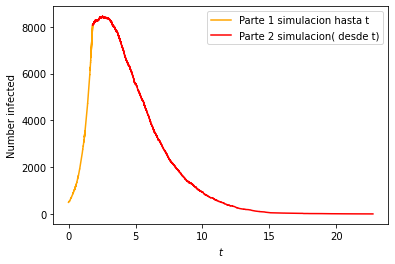

In [118]:
#Representacion

#Pintamos solo la parte 1 de la simulacion
lista1= list(tiempos_parte1_ejem3[:index+1])
lista2= list(infectados_parte1_ejem3[:index+1])
plt.plot(lista1,lista2 , label = 'Parte 1 simulacion hasta t', color = 'orange')

#Pintamos solo la parte 2 de la simulacion 

plt.plot(tiempos_parte2_ejem3,infectados_parte2_ejem3 , label = 'Parte 2 simulacion( desde t)', color = 'red')
#plt.plot(1.80,0, '*')
plt.xlabel('$t$')
plt.ylabel('Number infected')
plt.legend()
plt.show()

In [153]:
######################################################################################
########################Aqui empieza la validación##################################
#######################################################################################

# VALIDACION


## 1 Creacion del grafo y definicion de parametros

In [119]:

N = 10**5#number of individuals

# grafo
tau = 0.3#transmission rate
gamma = 1.0 #recovery rate
rho = 0.005#initial fraction infected

# campo medio
# Infection rate, beta, and mean recovery rate, gamma.
I0, R0 = 500, 0 # 500 initial infected (0.005 of 10**5)
S0 = N - I0 - R0

In [120]:
#CREAR GRAFO ERDOS–RENYI -  (1M individuos, 5 conexiones de promedio)
kave = 10#expected number of partners

g = nx.fast_gnp_random_graph(N, kave/(N-1))#Erdo's-Re'nyi graph
t_g, S_g, I_g, R__g = EoN.fast_SIR(g, tau, gamma, rho=rho)

## 2 Definicion Modelo SIR

In [121]:
# campo medio
# Infection rate, beta, and mean recovery rate, gamma.
I0, R0 = 500, 0 # 500 initial infected (0.005 of 10**5)
S0 = N - I0 - R0

In [122]:
# The SIR model differential equations.
def sir(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0

t = np.linspace(start=0,stop=20)


## 3 Encontrando los parámetros optimos



## 3.1 Encontramos Parametros Optimos(Parte 1 de la simulacion)

In [123]:
#Ponemos nuestra funcion a fitear en formato correcto para pasarsela a scipy
y0 = S0, I0, R0

def fun_2_fit(xdata,beta,gamma):
    

    y = odeint(sir, y0, xdata, args=(beta, gamma))
    S = y[:,0]
    I = y[:,1]
    R = y[:,2]
    return I

In [124]:
#Fiteamos para encontrar los parametros optimos

f= fun_2_fit
xdata = lista1
ydata= lista2
#p0= [beta,gamma] estimados que creemos que pueden ser aproximados
p0= [ 0.000027, 1]

params, params_covariance = scipy.optimize.curve_fit(f, xdata, ydata, p0)


## 3.1.1 Obtenemos la grafica de la parte 1, integrando hasta t= 1.80

In [125]:
#Ya hemos obtenido los parametros, obtenemos la grafica con los parametros ajustados
beta_ajustado = params[0]
gamma_ajustado= params[1]
print("beta_ajustado:",beta_ajustado)
print("gamma_ajustado:",gamma_ajustado)
# Integrate the SIR equations over the time grid, t.
y = odeint(sir, y0, lista1, args=(beta_ajustado, gamma_ajustado))
S = y[:,0]
I = y[:,1]
R = y[:,2]

beta_ajustado: 2.3248633965096485e-05
gamma_ajustado: 0.6901515925051633


## 3.1.2 Dibujamos una vez obtenidos parametros optimos


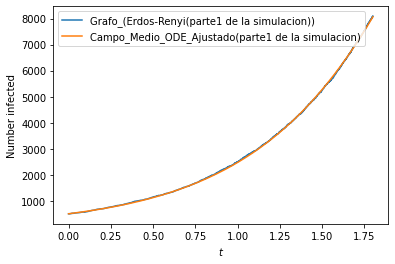

In [126]:

plt.plot(lista1, lista2, label = 'Grafo_(Erdos-Renyi(parte1 de la simulacion))')
#plt.plot(t,S,'r',label='S(t)_Campo_Medio')
plt.plot(lista1, I,label='Campo_Medio_ODE_Ajustado(parte1 de la simulacion)')
#plt.plot(t,R,'g',label='R(t)_Campo_Medio')
plt.ylabel('Number infected')
plt.xlabel('$t$')

#Ajuste de escala
#axes = plt.gca()
#axes.set_xlim([0,20])

plt.legend()
plt.show()


## 3.1.3 Test de Kolmogorov parte 1 de la simulación 

In [127]:
print(st.kstest(lista2,I))

KstestResult(statistic=0.009222586850741177, pvalue=0.4373057014724574)


Observamos un estadístico bajo, que nos confirma lo que veiamos graficamente: se el modelo a validar se ajusta en la parte 1 de nuestra simulacion

## 3.2 Encontramos Parametros Optimos(Parte 2 de la simulacion)

In [128]:
#Vector de condiciones iniciales(punto donde se continua con la segunda parte de la simulacion)
S1=len(susceptibles_ejem3)
I1=len(infectados_ejem3)
R1=len(recuperados_ejem3)
y1 = S1, I1, R1


def fun_2_fit(xdata,beta,gamma):
    

    y = odeint(sir, y1, xdata, args=(beta, gamma)) #AQUI LE PASAMOS Y1
    S = y[:,0]
    I = y[:,1]
    R = y[:,2]
    return I

In [129]:
#Fiteamos para encontrar los parametros optimos

f= fun_2_fit
xdata1 = tiempos_parte2_ejem3
ydata2 = infectados_parte2_ejem3
#p0= [beta,gamma] estimados que creemos que pueden ser aproximados
p0= [ 0.000027, 1]

params1, params_covariance1 = scipy.optimize.curve_fit(f, xdata, ydata, p0)

## 3.2.1 Obtenemos la grafica de la parte 2, integrando desde t= 1.80

In [130]:
#Ya hemos obtenido los parametros, obtenemos la grafica con los parametros ajustados
beta_ajustado1 = params1[0]
gamma_ajustado1= params1[1]
print("beta_ajustado:",beta_ajustado1)
print("gamma_ajustado:",gamma_ajustado1)
# Integrate the SIR equations over the time grid, t.
#t1 = np.linspace(start=1.8,stop=20)

y = odeint(sir, y1, xdata1, args=(beta_ajustado1, gamma_ajustado1))
S1 = y[:,0]
I1 = y[:,1]
R1 = y[:,2]

beta_ajustado: 7.376026658257544e-10
gamma_ajustado: 0.38780078670969587


## 3.2.2 Dibujamos una vez obtenidos parametros optimos

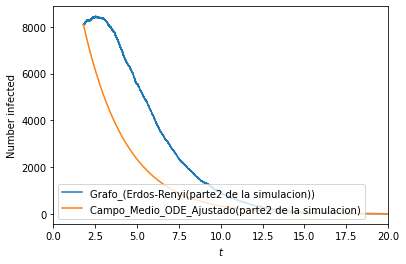

In [131]:

plt.plot(tiempos_parte2_ejem3, infectados_parte2_ejem3, label = 'Grafo_(Erdos-Renyi(parte2 de la simulacion))')
#plt.plot(t,S,'r',label='S(t)_Campo_Medio')
plt.plot(tiempos_parte2_ejem3, I1,label='Campo_Medio_ODE_Ajustado(parte2 de la simulacion)')
#plt.plot(t,R,'g',label='R(t)_Campo_Medio')
plt.ylabel('Number infected')
plt.xlabel('$t$')

#Ajuste de escala
axes = plt.gca()
axes.set_xlim([0,20])

plt.legend()
plt.show()


## 3.2.3 Test de Kolmogorov parte 2 de la simulación 

In [132]:
print(st.kstest(infectados_parte2_ejem3,I1))

KstestResult(statistic=0.4273636529885914, pvalue=0.0)


Obtenemos un valor alto para el estadístico. Lo que quiere decir que nuestro modelo de comportanmiento individual sobre una población no se adapta bién a un modelo de campo medio, como es el caso del ODE-SIR. A pesar de que gráficamente, podemos decir que tienen un comportanmiento en el tiempo similar, los datos distan bastante en aproximación.

# VALIDACION DE TODO EL MODELO EN CONJUNTO

## 1 Creacion del grafo y definicion de parametros

In [133]:

N = 10**5#number of individuals

# grafo
tau = 0.3#transmission rate
gamma = 1.0 #recovery rate
rho = 0.005#initial fraction infected

# campo medio
# Infection rate, beta, and mean recovery rate, gamma.
I0, R0 = 500, 0 # 500 initial infected (0.005 of 10**5)
S0 = N - I0 - R0

In [134]:
## 2 Definicion Modelo SIR

In [135]:
# campo medio
# Infection rate, beta, and mean recovery rate, gamma.
I0, R0 = 500, 0 # 500 initial infected (0.005 of 10**5)
S0 = N - I0 - R0

In [136]:
## 3.1 Encontramos Parametros Optimos(Parte 1 de la simulacion)

In [137]:
#Ponemos nuestra funcion a fitear en formato correcto para pasarsela a scipy
y0 = S0, I0, R0

def fun_2_fit(xdata,beta,gamma):
    

    y = odeint(sir, y0, xdata, args=(beta, gamma))
    S = y[:,0]
    I = y[:,1]
    R = y[:,2]
    return I

In [145]:
#Fiteamos para encontrar los parametros optimos

f= fun_2_fit
#xdata = np.array(tiempos_finales_ejem3)
#ydata= np.array( infectados_finales_ejem3)
xdata = np.append(lista1[:-1],tiempos_parte2_ejem3)
ydata= np.append( lista2[:-1],infectados_parte2_ejem3)

#p0= [beta,gamma] estimados que creemos que pueden ser aproximados
p0= [ 0.000027, 1]

params3, params_covariance3 = scipy.optimize.curve_fit(f, xdata, ydata, p0)


In [146]:
## 3.1.1 Obtenemos la grafica de la parte 1, integrando hasta t= 1.80

In [147]:
#Ya hemos obtenido los parametros, obtenemos la grafica con los parametros ajustados
beta_ajustado3 = params3[0]
gamma_ajustado3= params3[1]
print("beta_ajustado:",beta_ajustado3)
print("gamma_ajustado:",gamma_ajustado3)
# Integrate the SIR equations over the time grid, t.
y = odeint(sir, y0, xdata, args=(beta_ajustado3, gamma_ajustado3))
S = y[:,0]
I3 = y[:,1]
R = y[:,2]

beta_ajustado: 3.543175195601306e-05
gamma_ajustado: 2.114998662779861


In [148]:
#dibujamos

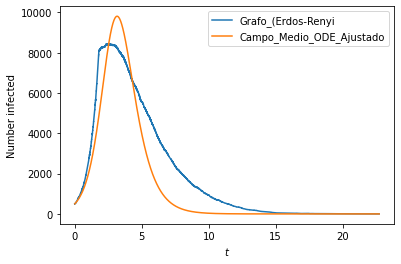

In [150]:

plt.plot(tiempos_finales_ejem3, infectados_finales_ejem3, label = 'Grafo_(Erdos-Renyi')
#plt.plot(t,S,'r',label='S(t)_Campo_Medio')
plt.plot(xdata, I3,label='Campo_Medio_ODE_Ajustado')
#plt.plot(t,R,'g',label='R(t)_Campo_Medio')
plt.ylabel('Number infected')
plt.xlabel('$t$')

#Ajuste de escala
#axes = plt.gca()
#axes.set_xlim([0,20])

plt.legend()
plt.show()

## Test de Kolmogorov de el conjunto de la simulacion con el modelo ODE-SIR

In [151]:
print(st.kstest(infectados_finales_ejem3,I3))

KstestResult(statistic=0.22391843515308307, pvalue=0.0)


No pasamos el test de kolmogorov(estadístico grande). Como podemos comprobar, el modelo de campo medio ODE-SIR, no es capaz de adaptarse bien a nuestro modelo cuando las interacciones individuales afectan a este. Con lo que no podríamos validar dichos resultados con un modelo de campo medio.